In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [16]:
# --------------------------
# 1. Hyperparameters
# --------------------------
batch_size = 64
num_classes = 34   # 0-9 + A-Z (change as per your dataset)
lr = 1e-3
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 2. Data Loading
# --------------------------
transform = transforms.Compose([
    transforms.Grayscale(),                   # ensure 1 channel
    transforms.Resize((64, 64)),              # resize characters
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))      # mean=0.5, std=0.5
])

train_dataset = datasets.ImageFolder(
    r"C:\Users\arnab\Documents\VIT\SET Project\OCR\dataset_split\train", 
    transform=transform
)
val_dataset = datasets.ImageFolder(
    r"C:\Users\arnab\Documents\VIT\SET Project\OCR\dataset_split\val", 
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
model = models.resnet18(weights=None)   # fresh ResNet-18
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # change input to 1-channel
model.fc = nn.Linear(model.fc.in_features, num_classes)  # new output layer
model = model.to(device)
# total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")


Total params: 11,187,682
Trainable params: 11,187,682


In [18]:
# --------------------------
# 3. Model Setup
# --------------------------


# --------------------------
# 4. Loss + Optimizer
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# --------------------------
# 5. Training Loop
# --------------------------
# --------------------------
# 5. Training Loop with val_loss
# --------------------------
best_val_acc = float('-inf')
patience = 5
patience_counter = 0

# For plotting
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100.0 * correct / total
    train_loss = running_loss / total

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100.0 * val_correct / val_total
    val_loss = val_running_loss / val_total

    # Store metrics
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Early stopping + save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "resnet18_best.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'train_loss': train_loss,
            'val_loss': val_loss
        }, "char_cnn_best_checkpoint.tar")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break

# --------------------------
# 6. Save Final Model
# --------------------------
torch.save(model.state_dict(), "resnet18_final.pth")
print("✅ Model training complete and model saved!")


Epoch 1/100 | Train Loss: 0.6232 | Val Loss: 0.3195 | Train Acc: 83.27% | Val Acc: 91.33%
Epoch 2/100 | Train Loss: 0.2342 | Val Loss: 0.3167 | Train Acc: 93.70% | Val Acc: 91.62%
Epoch 3/100 | Train Loss: 0.1834 | Val Loss: 0.2174 | Train Acc: 95.20% | Val Acc: 94.76%
Epoch 4/100 | Train Loss: 0.1446 | Val Loss: 0.2024 | Train Acc: 96.09% | Val Acc: 95.23%
Epoch 5/100 | Train Loss: 0.1251 | Val Loss: 0.2883 | Train Acc: 96.54% | Val Acc: 92.79%
Epoch 6/100 | Train Loss: 0.1034 | Val Loss: 0.2174 | Train Acc: 97.10% | Val Acc: 94.79%
Epoch 7/100 | Train Loss: 0.1002 | Val Loss: 0.2390 | Train Acc: 97.12% | Val Acc: 94.73%
Epoch 8/100 | Train Loss: 0.0773 | Val Loss: 0.2004 | Train Acc: 97.94% | Val Acc: 95.25%
Epoch 9/100 | Train Loss: 0.0665 | Val Loss: 0.2228 | Train Acc: 98.04% | Val Acc: 95.46%
Epoch 10/100 | Train Loss: 0.0555 | Val Loss: 0.1919 | Train Acc: 98.44% | Val Acc: 96.05%
Epoch 11/100 | Train Loss: 0.0467 | Val Loss: 0.2151 | Train Acc: 98.71% | Val Acc: 95.14%
Epoch 12

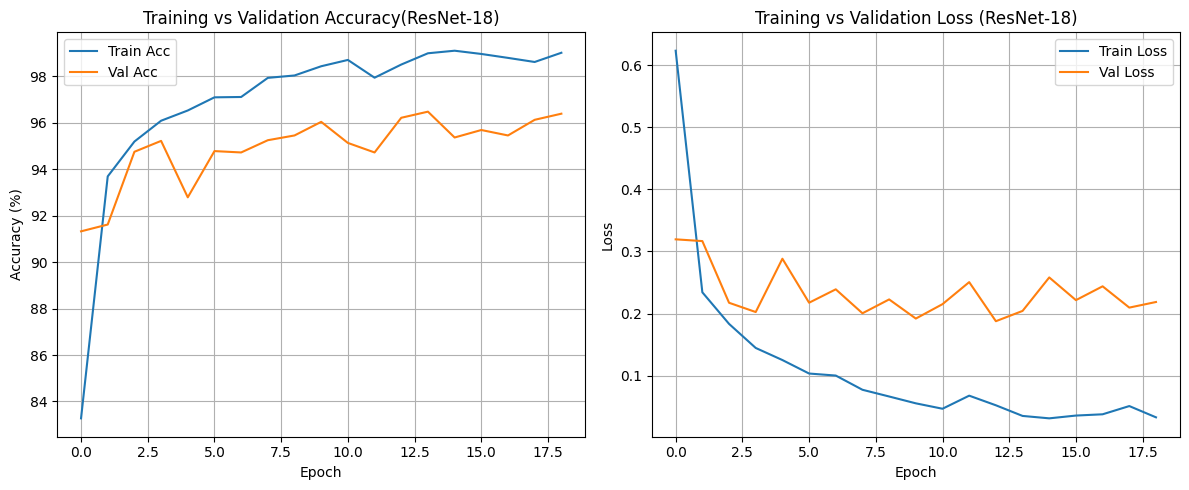

In [19]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy(ResNet-18)")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (ResNet-18)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
